In [39]:
import os
import sys

sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from tqdm import tqdm

from kwave.ktransducer import kWaveGrid
from models.DAS import DAS
from utils.data import load_mat
from utils.reconstruction import get_coordinates, wavefront_real
from utils.simulations import get_water_SoS
from utils.utils_torch import get_fourier_coord
from utils.visualization import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_path = '../data/'
results_path = '../results/'

### Sinogram

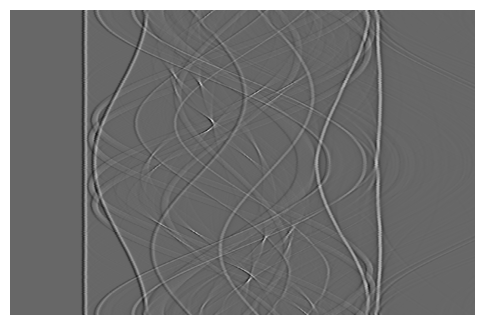

In [40]:
sinogram = load_mat(os.path.join(data_path, 'sinogram_simulation.mat'))

plt.figure(figsize=(6,4))
plt.imshow(sinogram[:,950:1730], cmap='gray')
plt.axis('off')
plt.savefig('sinogram.png', bbox_inches='tight', dpi=128)

### PSF Stack

In [41]:
i, j = 18, 15
x, y, r, phi = get_coordinates(i, j, 3.2e-3)
k2D, theta2D = get_fourier_coord(n_points=80, l=3.2e-3, device='cpu')

In [42]:
Nx, Ny = 560, 560
dx, dy = 4e-5, 4e-5
kgrid = kWaveGrid([Nx, Ny], [dx, dy])
x_vec, y_vec = kgrid.x_vec, kgrid.y_vec

In [43]:
R = 9.8e-3              # Radius of single body [m].
T = 26.0                # Water temperature [C].
v0 = get_water_SoS(T)   # Background SoS [m/s].
v1 = 1567.3             # Avergae SoS in single body [m/s].
print(v0, v1)

1499.3632858457756 1567.3


In [44]:
delays = np.linspace(-8e-4, 8e-4, 8)

w_real = wavefront_real(R, r, phi, v0, v1)
psfs = []
for delay in delays:
    psfs.append(PSF(theta2D, k2D, w_real, delay))

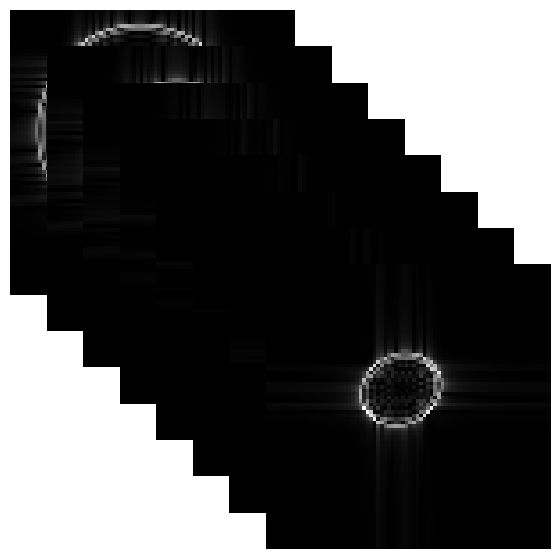

In [45]:
fig = plt.figure(figsize=(7,7), facecolor='white')
gs = GridSpec(15, 15)
for k in range(8):
    plt.subplot(gs[k:k+8,k:k+8])
    plt.imshow(psfs[k], cmap='gray')
    plt.axis('off')
plt.savefig('psf_stack.png', bbox_inches='tight', dpi=128)

### Full Image Stack

In [46]:
das = DAS(R_ring=0.05, N_transducer=512, T_sample=1/40e6, x_vec=x_vec, y_vec=y_vec, mode='zero', device=device)
das.to(device)
das.eval()

DAS()

In [47]:
img_stack = []
with torch.no_grad():
    for d_delay in tqdm(delays, desc='DAS'):
        recon = das(sinogram=torch.tensor(sinogram).to(device), 
                    v0=torch.tensor(v0, device=device),
                    d_delay=torch.tensor(d_delay, device=device),
                    ring_error=torch.zeros(1, device=device))
        img_stack.append(recon)
img_stack = torch.stack(img_stack, dim=0).detach().cpu().numpy()

DAS: 100%|██████████| 8/8 [00:00<00:00, 10.93it/s]


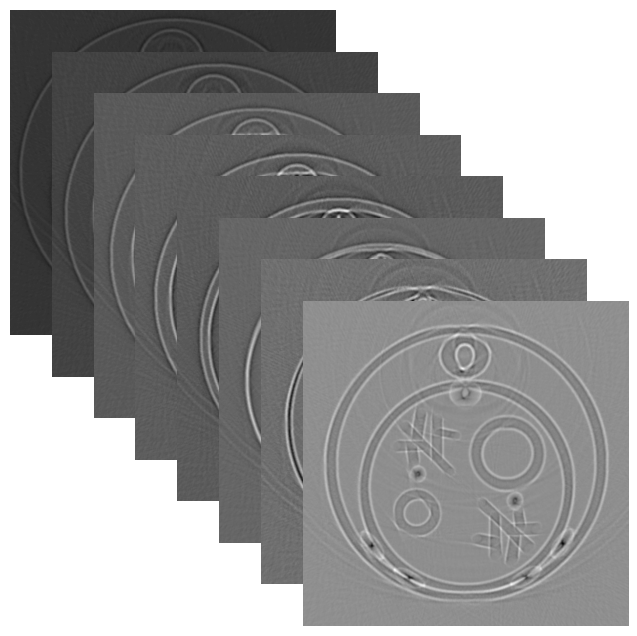

In [48]:
fig = plt.figure(figsize=(8,8), facecolor='white')
norm = Normalize(vmax=1, vmin=0)
step = 40
gs = GridSpec(15, 15)
for k in range(8):
    plt.subplot(gs[k:k+8,k:k+8])
    plt.imshow(normalize(img_stack[k,:,:]), cmap='gray', norm=norm)
    plt.axis('off')
plt.savefig('img_stack_full.png', bbox_inches='tight', dpi=128)

### Small Patch Image Stack

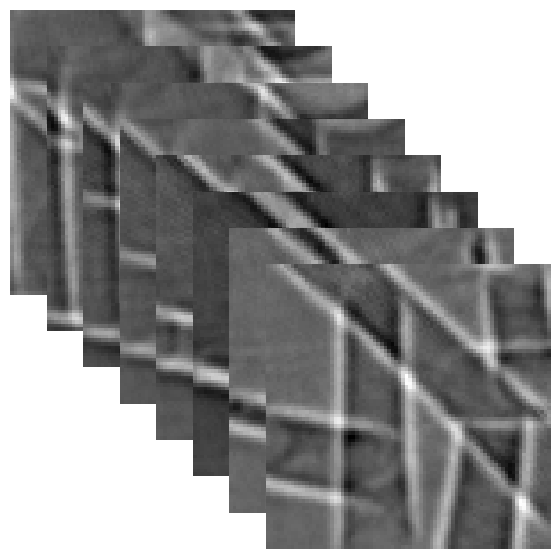

In [49]:
fig = plt.figure(figsize=(7,7), facecolor='white')
step = 40
gs = GridSpec(15, 15)
for k in range(8):
    plt.subplot(gs[k:k+8,k:k+8])
    plt.imshow(normalize(img_stack[k,20*i:20*i+80, 20*j:20*j+80]), cmap='gray', norm=norm)
    plt.axis('off')
plt.savefig('img_stack_patch.png', bbox_inches='tight', dpi=128)

### Deblurred Full Image

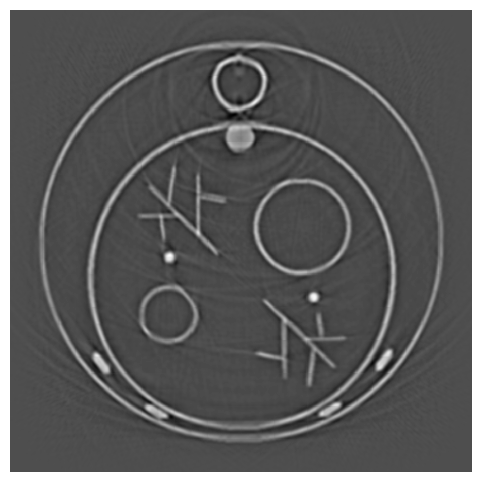

In [50]:
rec_wiener = load_mat(os.path.join(results_path, 'sb_wiener_simulation.mat')) 
rec_wiener = normalize(rec_wiener)

plt.figure(figsize=(6,6))
plt.imshow(rec_wiener, cmap='gray', norm=norm)
plt.axis('off')
plt.savefig('rec_wiener_full.png', bbox_inches='tight', dpi=128)

### Clean Small Patch

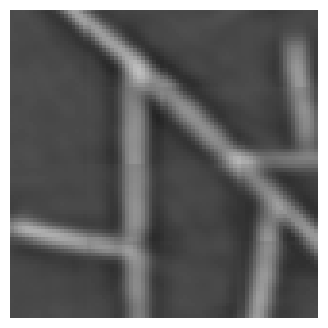

In [51]:
plt.figure(figsize=(4,4))
plt.imshow(rec_wiener[20*i:20*i+80, 20*j:20*j+80], cmap='gray', norm=norm)
plt.axis('off')
plt.savefig('rec_wiener_patch.png', bbox_inches='tight', dpi=128)

### Wavefront

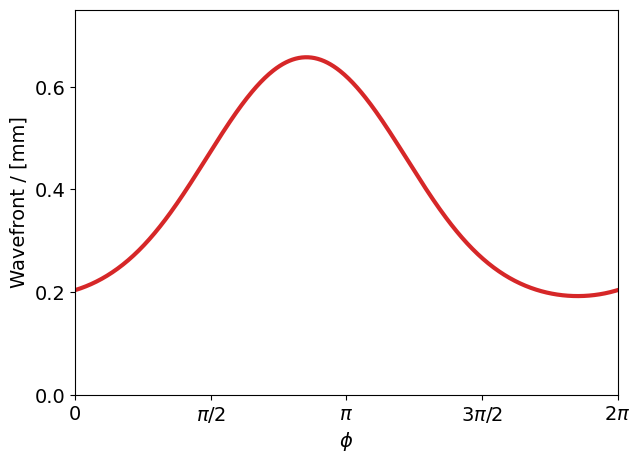

In [52]:
theta1D = torch.arange(0, 2*np.pi, 2*np.pi/512)

plt.figure(figsize=(7,5))
plt.plot(theta1D, w_real(theta1D)*1e3, color='tab:red', label='Real', linewidth=3)
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'], fontsize=14)
plt.yticks([0, 0.2, 0.4, 0.6], ['0.0', '0.2', '0.4', '0.6'], fontsize=14)
plt.xlim([0, 2*np.pi])
plt.ylim([0.0, 0.75])
plt.ylabel('Wavefront / [mm]', fontsize=14)
plt.xlabel('$\phi$', fontsize=14)
plt.savefig('wavefront.png', bbox_inches='tight', dpi=128)

### Single-body

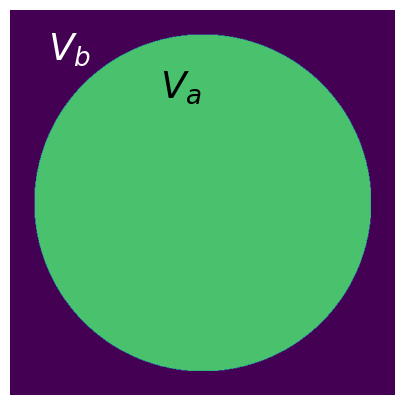

In [59]:
SoS_SB = load_mat(os.path.join(data_path, 'SoS_SB.mat'))

plt.figure(figsize=(5,5))
norm_sos = Normalize(vmax=1600, vmin=1500)
# plt.title('Speed of Sound Distribution', fontsize=15)
plt.title(loc='left', label='$V_b$', fontsize=27, y=0.85, x=0.1, color="white")
plt.title(loc='right', label='$V_a$', fontsize=27, y=0.75, x=0.5, color="black")
plt.imshow(SoS_SB, norm=norm_sos)
plt.axis('off')
plt.savefig('SoS_SB.png', bbox_inches='tight', dpi=128)